# Regression Model (Star Rating 2017-2018)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from category_encoders import OneHotEncoder 

In [2]:
data = pd.read_csv('../../01_data/cleaned_data/school_df_v6.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844 entries, 0 to 843
Data columns (total 56 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   code                         109 non-null    float64
 1   name                         109 non-null    object 
 2   grade_band                   109 non-null    object 
 3   enrollment_SY1718            109 non-null    float64
 4   enrollment_SY1819            109 non-null    float64
 5   star_score_SY1718            109 non-null    float64
 6   star_score_SY1819            109 non-null    float64
 7   star_rating_SY1718           109 non-null    float64
 8   star_rating_SY1819           109 non-null    float64
 9   capacity_SY1718              109 non-null    float64
 10  capacity_SY1819              109 non-null    float64
 11  latitude                     109 non-null    float64
 12  longitude                    109 non-null    float64
 13  cluster             

In [4]:
# drop unnamed columns and "bad import" full-nan rows
data = data.iloc[:,:45]
data.dropna(how='all', inplace=True)

In [5]:
# drop 2 schools that have no attendance data
data.drop(data[data['code'] == 201].index, inplace = True) # Oyster Adams Bilingual School (Adams) has no attendance data
data.drop(data[data['code'] == 347].index, inplace = True) # Brookland Middle School has no attendance data

In [6]:
# drop columns looking at "count" of absences (non-relatable across schools of different sizes)
X = data.drop(columns = data.filter(regex='^count',axis=1)).drop(columns='name')

In [7]:
# drop school_code
X.drop('code', axis = 1, inplace = True)

In [8]:
# drop columns looking at school year 18-19 and FY 17
X = X.drop(columns = X.filter(regex='SY1819$',axis=1)).drop(columns = data.filter(regex='FY17$',axis=1))

In [9]:
# OHE grade_band column
X_ohe = OneHotEncoder(cols=['grade_band']).fit_transform(X)

c:\programdata\miniconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


## Create no_nan_df
### Only looks at 82 rows
* Need a better solution for dealing with np.nan (originally cast as -1)

In [10]:
no_nan_df = X_ohe.replace(-1,np.nan)

In [11]:
no_nan_df.dropna(how='any',inplace=True)

In [12]:
no_nan_y = no_nan_df['star_rating_SY1718']
no_nan_X = no_nan_df.drop(columns=['star_score_SY1718','star_rating_SY1718'])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(no_nan_X, no_nan_y)

## Regression Models

In [14]:
def print_results(grid, X_train, X_test, y_train, y_test):
    #print(f'Estimator : {grid.get_estimator_}')
    
    print('*** TRAIN set ***')
    print(f'Score : {grid.score(X_train, y_train)}')
    print(f'RMSE: {mean_squared_error(y_train, grid.predict(X_train), squared = False)}')
    print(f'MSE: {mean_squared_error(y_train, grid.predict(X_train))}')
    print()
    print('*** TEST set ***')
    print(f'Score : {grid.score(X_test, y_test)}')
    print(f'RMSE: {mean_squared_error(y_test, grid.predict(X_test), squared = False)}')
    print(f'MSE: {mean_squared_error(y_test, grid.predict(X_test))}')
    print()
    print(f'Best Params : {grid.best_params_}')

    y_pred = grid.predict(X_test)
    fig, ax = plt.subplots(figsize=(4, 4))
    plt.scatter(y_test, y_pred)
    ax.plot([0,1], [0,1], transform=ax.transAxes, ls="--", c="orange")
    #plt.title('')
    plt.xlabel('Star Rating')
    plt.ylabel('Model Predictions');

### Multiple Linear Regression Model

*** TRAIN set ***
Score : 1.0
RMSE: 5.670924623862567e-15
MSE: 3.2159386089530794e-29

*** TEST set ***
Score : -12.664303886766982
RMSE: 4.4877756678947485
MSE: 20.14013044534816

Best Params : {'lr__normalize': 'True'}


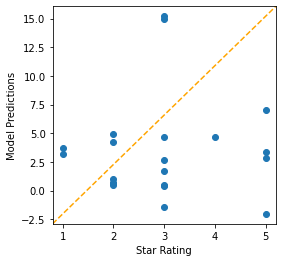

In [15]:
pipe = Pipeline([('poly', PolynomialFeatures()), ('scaler', StandardScaler()), ('lr', LinearRegression())])
param = [
    {'lr__normalize': ['True','False']}
]
grid = GridSearchCV(pipe, param, n_jobs = -1)
grid.fit(X_train, y_train)
print_results(grid, X_train, X_test, y_train, y_test)

### Ridge Model

*** TRAIN set ***
Score : 0.7850238460289342
RMSE: 0.5191522981090454
MSE: 0.26951910863190315

*** TEST set ***
Score : 0.630242806676226
RMSE: 0.7382368153932276
MSE: 0.5449935956019345

Best Params : {'ridge__alpha': 100}


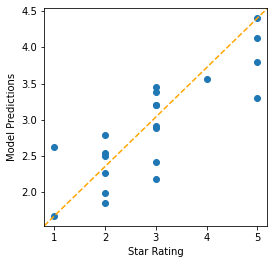

In [16]:
pipe1 = Pipeline([('poly', PolynomialFeatures()), ('scaler', StandardScaler()), ('ridge', Ridge())])
param1 = [
    {'ridge__alpha': [.01, .1, 1, 10, 100]}
]
grid1 = GridSearchCV(pipe1, param1, n_jobs = -1)
grid1.fit(X_train, y_train)
print_results(grid1, X_train, X_test, y_train, y_test)

### KNeighbors Model

*** TRAIN set ***
Score : 0.6640186946932051
RMSE: 0.6490186741589625
MSE: 0.42122523940705764

*** TEST set ***
Score : 0.6280610298792118
RMSE: 0.7404116195679161
MSE: 0.5482093663911846

Best Params : {'knearest__n_neighbors': 11}


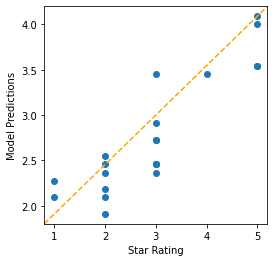

In [17]:
pipe2 = Pipeline([('poly', PolynomialFeatures()), ('scaler', StandardScaler()), ('knearest', KNeighborsRegressor())])
param2 = [
    {'knearest__n_neighbors': [3,7,11,25,35]}
]
grid2 = GridSearchCV(pipe2, param2, n_jobs = -1)
grid2.fit(X_train, y_train)
print_results(grid2, X_train, X_test, y_train, y_test)

### Decision Tree Model

*** TRAIN set ***
Score : 0.7558457064497824
RMSE: 0.5532632446357916
MSE: 0.3061002178649238

*** TEST set ***
Score : 0.4073584863809776
RMSE: 0.9346164453357234
MSE: 0.8735078998919832

Best Params : {'dtree__ccp_alpha': 0.1, 'dtree__max_depth': 3, 'dtree__min_samples_leaf': 3, 'dtree__min_samples_split': 7}


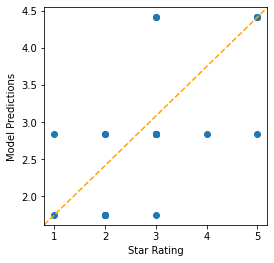

In [18]:
pipe3 = Pipeline([('poly', PolynomialFeatures()), ('scaler', StandardScaler()), ('dtree', DecisionTreeRegressor())])
param3 = [
    {'dtree__max_depth':[3,5,7,9],
    'dtree__min_samples_split':[3,5,7,9], 
    'dtree__min_samples_leaf':[3,5,7,9], 
    'dtree__ccp_alpha':[.01, .1, 1, 10, 100]}
]
grid3 = GridSearchCV(pipe3, param3, n_jobs = -1)
grid3.fit(X_train, y_train)
print_results(grid3, X_train, X_test, y_train, y_test)

### Bagged Decision Tree Model

*** TRAIN set ***
Score : 0.9460600482315112
RMSE: 0.26004883546248925
MSE: 0.06762539682539681

*** TEST set ***
Score : 0.683278
RMSE: 0.6832450581773787
MSE: 0.46682380952380953

Best Params : {'btree__n_estimators': 100}


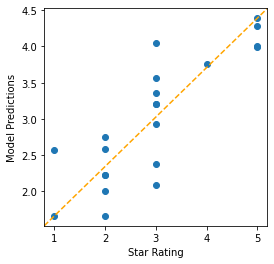

In [19]:
pipe4 = Pipeline([('poly', PolynomialFeatures()), ('scaler', StandardScaler()), ('btree', BaggingRegressor())])
param4 = [
    {'btree__n_estimators':[50, 100, 500]}
]
grid4 = GridSearchCV(pipe4, param4, n_jobs = -1)
grid4.fit(X_train, y_train)
print_results(grid4, X_train, X_test, y_train, y_test)

### Random Forest Model

*** TRAIN set ***
Score : 0.8239374801936948
RMSE: 0.4698217227154812
MSE: 0.22073245113534254

*** TEST set ***
Score : 0.6902380008634226
RMSE: 0.6756961631161085
MSE: 0.45656530484983066

Best Params : {'randforest__max_depth': 7, 'randforest__min_samples_leaf': 7, 'randforest__min_samples_split': 5, 'randforest__n_estimators': 100}


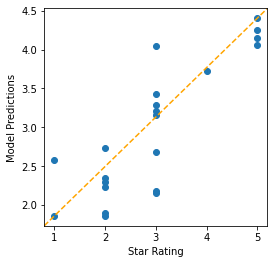

In [20]:
pipe5 = Pipeline([('poly', PolynomialFeatures()), ('scaler', StandardScaler()), ('randforest', RandomForestRegressor())])
param5 = [
    {'randforest__max_depth':[3,5,7,9],
    'randforest__min_samples_split':[3,5,7,9], 
    'randforest__min_samples_leaf':[3,5,7,9], 
    'randforest__n_estimators':[50, 100, 500]}
]
grid5 = GridSearchCV(pipe5, param5, n_jobs = -1)
grid5.fit(X_train, y_train)
print_results(grid5, X_train, X_test, y_train, y_test)

### Adaboost Model

*** TRAIN set ***
Score : 0.9927319368240543
RMSE: 0.09545726416998557
MSE: 0.00911208928281841

*** TEST set ***
Score : 0.6424497973076424
RMSE: 0.7259486431833565
MSE: 0.5270014325397562

Best Params : {'ada__n_estimators': 500}


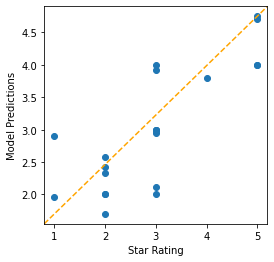

In [21]:
pipe6 = Pipeline([('poly', PolynomialFeatures()), ('scaler', StandardScaler()), ('ada', AdaBoostRegressor())])
param6 = [
    {'ada__n_estimators':[50, 100, 500]}
]
grid6 = GridSearchCV(pipe6, param6, n_jobs = -1)
grid6.fit(X_train, y_train)
print_results(grid6, X_train, X_test, y_train, y_test)

### Support Vector Regressor Model

#### Was only able to get a very limited SVM to ever execute fully.

*** TRAIN set ***
Score : 0.786098279020012
RMSE: 0.5178533329778776
MSE: 0.26817207447629654

*** TEST set ***
Score : 0.549997855279674
RMSE: 0.814412958685492
MSE: 0.6632684672748569

Best Params : {'svr__C': 0.01, 'svr__gamma': 0.01, 'svr__kernel': 'linear'}


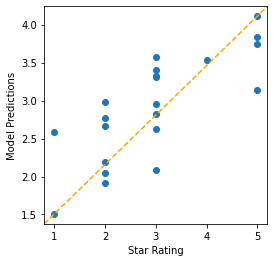

In [22]:
pipe7 = Pipeline([('poly', PolynomialFeatures()), ('scaler', StandardScaler()), ('svr', SVR())])
param7 = [
    {'svr__kernel': ['linear'],
     'svr__C': [.01, 1, 10],
     'svr__gamma': np.logspace(-2, 2, 20)
    }
#     {'svr__kernel': ['linear', 'poly'],
#      'svr__C': [.01, 1, 100],
#      'svr__gamma': np.logspace(-5, 2, 20)
#     }
]
grid7 = GridSearchCV(pipe7, param7, n_jobs = -1)
grid7.fit(X_train, y_train)
print_results(grid7, X_train, X_test, y_train, y_test)

<br><br>
<br><br>

# Regression Model (Star Score 2017-2018)

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from category_encoders import OneHotEncoder 

In [24]:
data = pd.read_csv('../../01_data/cleaned_data/school_df_v6.csv')

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844 entries, 0 to 843
Data columns (total 56 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   code                         109 non-null    float64
 1   name                         109 non-null    object 
 2   grade_band                   109 non-null    object 
 3   enrollment_SY1718            109 non-null    float64
 4   enrollment_SY1819            109 non-null    float64
 5   star_score_SY1718            109 non-null    float64
 6   star_score_SY1819            109 non-null    float64
 7   star_rating_SY1718           109 non-null    float64
 8   star_rating_SY1819           109 non-null    float64
 9   capacity_SY1718              109 non-null    float64
 10  capacity_SY1819              109 non-null    float64
 11  latitude                     109 non-null    float64
 12  longitude                    109 non-null    float64
 13  cluster             

In [26]:
# drop unnamed columns and "bad import" full-nan rows
data = data.iloc[:,:45]
data.dropna(how='all', inplace=True)

In [27]:
# drop 2 schools that have no attendance data
data.drop(data[data['code'] == 201].index, inplace = True) # Oyster Adams Bilingual School (Adams) has no attendance data
data.drop(data[data['code'] == 347].index, inplace = True) # Brookland Middle School has no attendance data

In [28]:
# drop columns looking at "count" of absences (non-relatable across schools of different sizes)
X = data.drop(columns = data.filter(regex='^count',axis=1)).drop(columns='name')

In [29]:
# drop school_code
X.drop('code', axis = 1, inplace = True)

In [30]:
# drop columns looking at school year 18-19 and FY 17
X = X.drop(columns = X.filter(regex='SY1819$',axis=1)).drop(columns = data.filter(regex='FY17$',axis=1))

In [31]:
# OHE grade_band column
X_ohe = OneHotEncoder(cols=['grade_band']).fit_transform(X)

c:\programdata\miniconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


<br><br>

# Create no_nan_df
### Only looks at 82 rows
* Need a better solution for dealing with np.nan (originally cast as -1)

In [32]:
no_nan_df = X_ohe.replace(-1,np.nan)

In [33]:
no_nan_df.dropna(how='any',inplace=True)

In [34]:
no_nan_y = no_nan_df['star_score_SY1718']
no_nan_X = no_nan_df.drop(columns=['star_score_SY1718','star_rating_SY1718'])

In [35]:
X_train, X_test, y_train, y_test = train_test_split(no_nan_X, no_nan_y)

<br><br>
# Regression Models

In [36]:
def print_results(grid, X_train, X_test, y_train, y_test):
    #print(f'Estimator : {grid.get_estimator_}')
    
    print('*** TRAIN set ***')
    print(f'Score : {grid.score(X_train, y_train)}')
    print(f'RMSE: {mean_squared_error(y_train, grid.predict(X_train), squared = False)}')
    print(f'MSE: {mean_squared_error(y_train, grid.predict(X_train))}')
    print()
    print('*** TEST set ***')
    print(f'Score : {grid.score(X_test, y_test)}')
    print(f'RMSE: {mean_squared_error(y_test, grid.predict(X_test), squared = False)}')
    print(f'MSE: {mean_squared_error(y_test, grid.predict(X_test))}')
    print()
    print(f'Best Params : {grid.best_params_}')

    y_pred = grid.predict(X_test)
    fig, ax = plt.subplots(figsize=(4, 4))
    plt.scatter(y_test, y_pred)
    ax.plot([0,1], [0,1], transform=ax.transAxes, ls="--", c="orange")
    #plt.title('')
    plt.xlabel('Star Rating')
    plt.ylabel('Model Predictions');

<br><br>

### Multiple Linear Regression Model

In [37]:
pipe = Pipeline([('poly', PolynomialFeatures()), ('scaler', StandardScaler()), ('lr', LinearRegression())])
param = [
    {'lr__normalize': ['True','False']}
]
grid = GridSearchCV(pipe, param, n_jobs = -1)
grid.fit(X_train, y_train);
# print_results(grid, X_train, X_test, y_train, y_test)

<br><br>

### Ridge Model

*** TRAIN set ***
Score : 0.844318372051554
RMSE: 9.431324993366827
MSE: 88.94989113050579

*** TEST set ***
Score : 0.7262123601194417
RMSE: 11.354929244623948
MSE: 128.93441815041618

Best Params : {'ridge__alpha': 100}


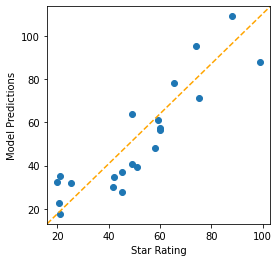

In [38]:
pipe1 = Pipeline([('poly', PolynomialFeatures()), ('scaler', StandardScaler()), ('ridge', Ridge())])
param1 = [
    {'ridge__alpha': [.01, .1, 1, 10, 100]}
]
grid1 = GridSearchCV(pipe1, param1, n_jobs = -1)
grid1.fit(X_train, y_train)
print_results(grid1, X_train, X_test, y_train, y_test)

<br><br>

### KNeighbors Model

*** TRAIN set ***
Score : 0.7335288101214645
RMSE: 12.338977118445802
MSE: 152.25035632952907

*** TEST set ***
Score : 0.7373792582545788
RMSE: 11.120953507968952
MSE: 123.67560692640696

Best Params : {'knearest__n_neighbors': 11}


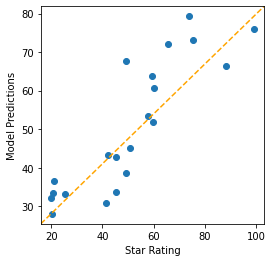

In [39]:
pipe2 = Pipeline([('poly', PolynomialFeatures()), ('scaler', StandardScaler()), ('knearest', KNeighborsRegressor())])
param2 = [
    {'knearest__n_neighbors': [3,7,11,25,35]}
]
grid2 = GridSearchCV(pipe2, param2, n_jobs = -1)
grid2.fit(X_train, y_train)
print_results(grid2, X_train, X_test, y_train, y_test)

<br><br>

### Decision Tree Model

*** TRAIN set ***
Score : 0.9735944357053491
RMSE: 3.8842015277192434
MSE: 15.087021507936505

*** TEST set ***
Score : 0.5314856826873864
RMSE: 14.85384702178398
MSE: 220.63677134656086

Best Params : {'dtree__ccp_alpha': 1, 'dtree__max_depth': 9, 'dtree__min_samples_leaf': 3, 'dtree__min_samples_split': 3}


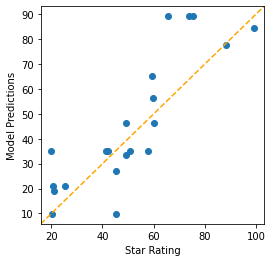

In [40]:
pipe3 = Pipeline([('poly', PolynomialFeatures()), ('scaler', StandardScaler()), ('dtree', DecisionTreeRegressor())])
param3 = [
    {'dtree__max_depth':[3,5,7,9],
    'dtree__min_samples_split':[3,5,7,9], 
    'dtree__min_samples_leaf':[3,5,7,9], 
    'dtree__ccp_alpha':[.01, .1, 1, 10, 100]}
]
grid3 = GridSearchCV(pipe3, param3, n_jobs = -1)
grid3.fit(X_train, y_train)
print_results(grid3, X_train, X_test, y_train, y_test)

<br><br>

### Bagged Decision Tree Model

*** TRAIN set ***
Score : 0.9699590585478057
RMSE: 4.142960548341891
MSE: 17.164122105117347

*** TEST set ***
Score : 0.5984008759251624
RMSE: 13.752254213740123
MSE: 189.12449595933296

Best Params : {'btree__n_estimators': 500}


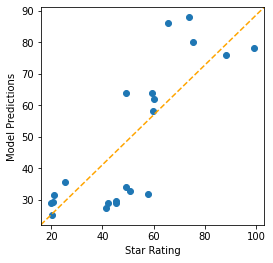

In [41]:
pipe4 = Pipeline([('poly', PolynomialFeatures()), ('scaler', StandardScaler()), ('btree', BaggingRegressor())])
param4 = [
    {'btree__n_estimators':[50, 100, 500]}
]
grid4 = GridSearchCV(pipe4, param4, n_jobs = -1)
grid4.fit(X_train, y_train)
print_results(grid4, X_train, X_test, y_train, y_test)

<br><br>

### Random Forest Model

*** TRAIN set ***
Score : 0.9429405881093169
RMSE: 5.709757633655736
MSE: 32.60133223508994

*** TEST set ***
Score : 0.5875515234983676
RMSE: 13.936777455393253
MSE: 194.23376584115766

Best Params : {'randforest__max_depth': 5, 'randforest__min_samples_leaf': 3, 'randforest__min_samples_split': 9, 'randforest__n_estimators': 100}


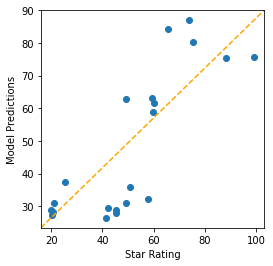

In [42]:
pipe5 = Pipeline([('poly', PolynomialFeatures()), ('scaler', StandardScaler()), ('randforest', RandomForestRegressor())])
param5 = [
    {'randforest__max_depth':[3,5,7,9],
    'randforest__min_samples_split':[3,5,7,9], 
    'randforest__min_samples_leaf':[3,5,7,9], 
    'randforest__n_estimators':[50, 100, 500]}
]
grid5 = GridSearchCV(pipe5, param5, n_jobs = -1)
grid5.fit(X_train, y_train)
print_results(grid5, X_train, X_test, y_train, y_test)

<br><br>

### Adaboost Model

*** TRAIN set ***
Score : 0.9730954589572369
RMSE: 3.92072897516183
MSE: 15.372115696673534

*** TEST set ***
Score : 0.5689657230623081
RMSE: 14.247327820319212
MSE: 202.9863500196418

Best Params : {'ada__n_estimators': 50}


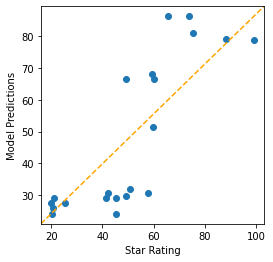

In [43]:
pipe6 = Pipeline([('poly', PolynomialFeatures()), ('scaler', StandardScaler()), ('ada', AdaBoostRegressor())])
param6 = [
    {'ada__n_estimators':[50, 100, 500]}
]
grid6 = GridSearchCV(pipe6, param6, n_jobs = -1)
grid6.fit(X_train, y_train)
print_results(grid6, X_train, X_test, y_train, y_test)

<br><br>

### Support Vector Regressor Model

#### Was only able to get a very limited SVM to ever execute fully.

*** TRAIN set ***
Score : 0.7190619870088184
RMSE: 12.669494329904868
MSE: 160.51608657549158

*** TEST set ***
Score : 0.7522207846613278
RMSE: 10.802143690640506
MSE: 116.68630831324448

Best Params : {'svr__C': 0.01, 'svr__gamma': 0.01, 'svr__kernel': 'linear'}


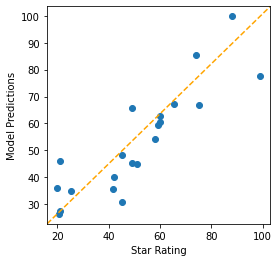

In [44]:
pipe7 = Pipeline([('poly', PolynomialFeatures()), ('scaler', StandardScaler()), ('svr', SVR())])
param7 = [
    {'svr__kernel': ['linear'],
     'svr__C': [.01, 1, 10],
     'svr__gamma': np.logspace(-2, 2, 20)
    }
#     {'svr__kernel': ['linear', 'poly'],
#      'svr__C': [.01, 1, 100],
#      'svr__gamma': np.logspace(-5, 2, 20)
#     }
]
grid7 = GridSearchCV(pipe7, param7, n_jobs = -1)
grid7.fit(X_train, y_train)
print_results(grid7, X_train, X_test, y_train, y_test)